In [2]:
!unzip '/content/data.zip' -d dataset

Archive:  /content/data.zip
   creating: dataset/data/
  inflating: dataset/__MACOSX/._data  
  inflating: dataset/data/.DS_Store  
  inflating: dataset/__MACOSX/data/._.DS_Store  
   creating: dataset/data/no/
   creating: dataset/data/yes/
  inflating: dataset/data/no/30 no.jpg  
  inflating: dataset/__MACOSX/data/no/._30 no.jpg  
  inflating: dataset/data/no/22 no.jpg  
  inflating: dataset/__MACOSX/data/no/._22 no.jpg  
  inflating: dataset/data/no/41 no.jpg  
  inflating: dataset/__MACOSX/data/no/._41 no.jpg  
  inflating: dataset/data/no/14 no.jpg  
  inflating: dataset/__MACOSX/data/no/._14 no.jpg  
  inflating: dataset/data/no/no 10.jpg  
  inflating: dataset/__MACOSX/data/no/._no 10.jpg  
  inflating: dataset/data/no/18 no.jpg  
  inflating: dataset/__MACOSX/data/no/._18 no.jpg  
  inflating: dataset/data/no/no 9.png  
  inflating: dataset/__MACOSX/data/no/._no 9.png  
  inflating: dataset/data/no/no 7.jpeg  
  inflating: dataset/__MACOSX/data/no/._no 7.jpeg  
  inflating: dat

## Import libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from PIL import Image

In [4]:
IMAGE_SIZE = 128

### buil function to handle the input data

In [5]:
def data_loading(p,l):
    data = []
    paths = []
    labels = []
    
    # with tumors
    for r, d, f in os.walk(p[0]):
        for file in f:
            if '.jpg'  in file:
                paths.append(os.path.join(r, file))

    for path in paths:
        img = Image.open(path)
        img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
        img = np.array(img)
        if(img.shape == (IMAGE_SIZE,IMAGE_SIZE,3)):
            data.append(np.array(img))
            labels.append(l[0])
    
    # with no tumors
    paths = []
    for r, d, f in os.walk(p[1]):
        for file in f:
            if '.jpg' in file:
                paths.append(os.path.join(r, file))

    for path in paths:
        img = Image.open(path)
        img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
        img = np.array(img)
        if(img.shape == (IMAGE_SIZE,IMAGE_SIZE,3)):
            data.append(np.array(img))
            labels.append(l[1])
    
    return data,labels

## Load the data

In [6]:
data,labels = data_loading(
    [
      '/content/dataset/data/yes',
      '/content/dataset/data/no'
    ],
    [
      1,
      0
    ]
)

data = np.array(data)
labels = np.array(labels)

labels = labels.reshape(139,1)

labels.shape,data.shape

((139, 1), (139, 128, 128, 3))

#### find minimum and maximum value of the data

In [7]:
print(np.max(data))
print(np.min(data))

255
0


#### rescale the data into black and white

In [8]:
data = data / 255.0

### plot random data

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


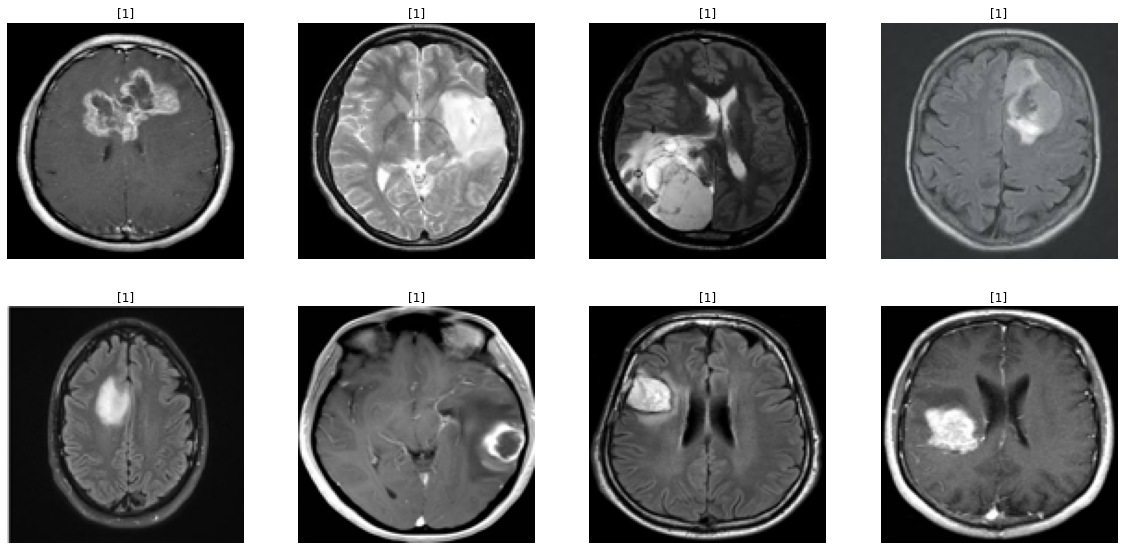

In [9]:
plt.figure(figsize=(20,20))
for i in range(0,8):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i])
    plt.title(labels[i])
    plt.axis("off")

## Split data into Train,Test

In [10]:
x_train,x_test,y_train,y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=42)

## Build the Model

In [11]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [30]:
input_shape = (data.shape[0],IMAGE_SIZE, IMAGE_SIZE,3)

model = keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=input_shape),
    keras.layers.MaxPool2D(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    keras.layers.MaxPool2D(),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(.2),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding='valid'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(.2),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    keras.layers.MaxPool2D(),

    keras.layers.Flatten(),
    keras.layers.Dropout(.25),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (139, 128, 128, 32)       2432      
                                                                 
 max_pooling2d_10 (MaxPoolin  (139, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (139, 64, 64, 64)         18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (139, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (139, 32, 32, 128)       

In [31]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to prevent overfitting
# early_stopping = keras.callbacks.EarlyStopping(
#     patience=10,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [32]:
Learning_Cycle = 5

In [33]:
for i in range(0,Learning_Cycle):
    history = model.fit(
      x = x_train,
      y = y_train,
      # validation_data= (x_test,y_test),
      batch_size = 64,
      epochs=100,
      # callbacks=[early_stopping],
      verbose=(2),
    )

Epoch 1/100
2/2 - 1s - loss: 0.6964 - accuracy: 0.4536 - 1s/epoch - 585ms/step
Epoch 2/100
2/2 - 0s - loss: 0.6907 - accuracy: 0.5258 - 100ms/epoch - 50ms/step
Epoch 3/100
2/2 - 0s - loss: 0.6925 - accuracy: 0.4639 - 92ms/epoch - 46ms/step
Epoch 4/100
2/2 - 0s - loss: 0.6955 - accuracy: 0.5052 - 74ms/epoch - 37ms/step
Epoch 5/100
2/2 - 0s - loss: 0.6885 - accuracy: 0.4948 - 74ms/epoch - 37ms/step
Epoch 6/100
2/2 - 0s - loss: 0.6965 - accuracy: 0.4742 - 72ms/epoch - 36ms/step
Epoch 7/100
2/2 - 0s - loss: 0.6916 - accuracy: 0.4948 - 72ms/epoch - 36ms/step
Epoch 8/100
2/2 - 0s - loss: 0.6986 - accuracy: 0.4536 - 70ms/epoch - 35ms/step
Epoch 9/100
2/2 - 0s - loss: 0.6940 - accuracy: 0.4742 - 68ms/epoch - 34ms/step
Epoch 10/100
2/2 - 0s - loss: 0.6933 - accuracy: 0.4742 - 72ms/epoch - 36ms/step
Epoch 11/100
2/2 - 0s - loss: 0.6967 - accuracy: 0.4433 - 69ms/epoch - 35ms/step
Epoch 12/100
2/2 - 0s - loss: 0.6878 - accuracy: 0.4742 - 72ms/epoch - 36ms/step
Epoch 13/100
2/2 - 0s - loss: 0.6908 

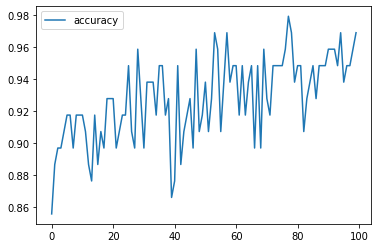

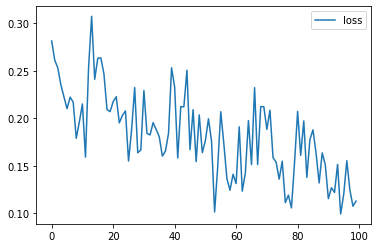

In [34]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy']].plot()
history_frame.loc[:, ['loss']].plot()

## Check the model prediction

In [35]:
image_idx = 20

The Image Label :  1
-------------------------------
The Prediction label are :  1
-------------------------------



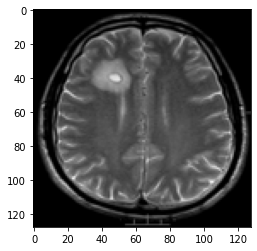

In [36]:
plt.imshow(x_test[image_idx])
print("The Image Label : ",int(y_test[image_idx]))
print('-------------------------------')
prediction = model.predict(x_test)
print("The Prediction label are : ",int(np.round(prediction[image_idx])))
print('-------------------------------')
print('')

## Save the Model

In [40]:
model.save('/content/brain_disease_model',save_format='h5')